In [464]:
!pip install numpy scipy matplotlib neuron --quiet

In [465]:
import numpy as np
import pylab as plt
plt.ion()
from scipy.optimize import curve_fit
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [466]:
!nrnivmodl > null.out

/home/tnieus/anaconda3/envs/neuron2425/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


In [467]:
from neuron import h
soma = h.Section(name='soma')
soma.L = 10
soma.diam = 10
soma.insert('sodium')
soma.insert('potassium')
soma.insert('leak')
soma.ena = 55 # mV
soma.ek = -77 # mV

# Action potential

With respect to *hh_mod_vclamp.ipynb* we add another current clamp electrode, to hyperpolarize the membrane at the beginning of the simulation.

In [468]:
iclamp = h.IClamp(soma(0.5))
iclamp.delay = 3
iclamp.dur = 1
iclamp.amp = 0.4 # 0.9

iclamp1 = h.IClamp(soma(0.5))
iclamp1.delay = 0
iclamp1.dur = 3
iclamp1.amp = -0.1

v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
t = h.Vector().record(h._ref_t)                     # Time stamp vector

# m
minf = h.Vector().record(soma(0.5)._ref_minf_sodium) # minf
mtau = h.Vector().record(soma(0.5)._ref_mtau_sodium) # mtau

# h
hinf = h.Vector().record(soma(0.5)._ref_hinf_sodium) # hinf
htau = h.Vector().record(soma(0.5)._ref_htau_sodium) # htau

# n
ninf = h.Vector().record(soma(0.5)._ref_ninf_potassium) 
ntau = h.Vector().record(soma(0.5)._ref_ntau_potassium)    

In [469]:
soma.gnabar_sodium = 0.12
soma.gkbar_potassium = 0.036

In [470]:
h.load_file('stdrun.hoc')
h.finitialize(-65)
h.tstop=10
h.run()

0.0

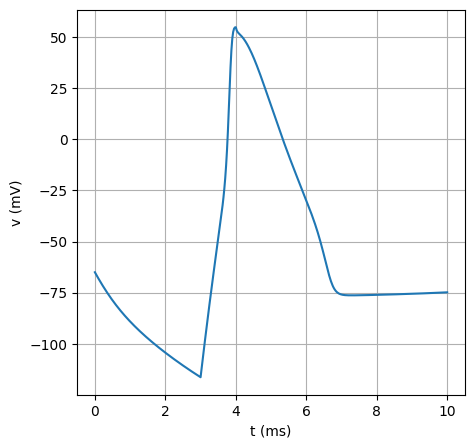

In [471]:
plt.figure(figsize=(5,5))
plt.plot(t, v)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.grid()

The initial hyperpolarization is pretty evident here.

What would be the time constant of the membrane without the active channels?

To get an estimate, remember that: 

$\tau_m=\frac{C_m}{g_{leak}}$

so ...

In [472]:
"""
units of measure:
    soma.cm -> microFarad / cm^2 ms
    soma.gl_leak -> S / cm^2
    soma.cm / soma.gl_leak -> (10^-6 F / cm^2) / (S / cm^2) = 10^-6 seconds = 10^-3 milli-seconds
"""

tau_cut_off = soma.cm * (1/soma.gl_leak) * 1e-6 * 1e3  
print("The time constant of the membrane is: %g (ms)" % tau_cut_off)

The time constant of the membrane is: 3.33333 (ms)


How much do the active channels affect the time course of the membrane potential in the initial phase?

In [473]:
soma.gnabar_sodium = 0 # 0.12
soma.gkbar_potassium = 0 # 0.036

# keep a copy of previous run:
v_active = np.array(v).copy()
t_active = np.array(t).copy()

In [474]:
#h.load_file('stdrun.hoc')
# perform another run
h.finitialize(-65)
h.tstop=10
h.run()

0.0

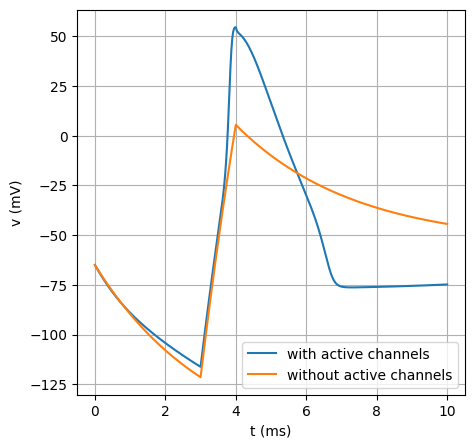

In [475]:
plt.figure(figsize=(5,5))
plt.plot(t_active, v_active, label="with active channels")
plt.plot(t, v, label="without active channels")
# decorate plot
plt.legend(loc=0)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.grid()

At voltages below -75 mV we expect only the hyperpolarizing $K^+$ current to operate. 

**So why does the voltage curve with active channels is above the one without active ones?**

Let us switch ON/OFF the sodium anche potassium channels to verify this!

In [476]:
soma.gnabar_sodium = 0.12 # 0
soma.gkbar_potassium = 0 # 0.036

# keep a copy of previous run:
v_passive = np.array(v).copy()
t_passive = np.array(t).copy()

h.finitialize(-65)
h.tstop=10
h.run()

0.0

In [477]:
soma.gnabar_sodium = 0
soma.gkbar_potassium = 0.036

# keep a copy of previous run:
v_sodium = np.array(v).copy()
t_sodium = np.array(t).copy()

h.finitialize(-65)
h.tstop=10
h.run()

v_potassium = np.array(v).copy()
t_potassium = np.array(t).copy()

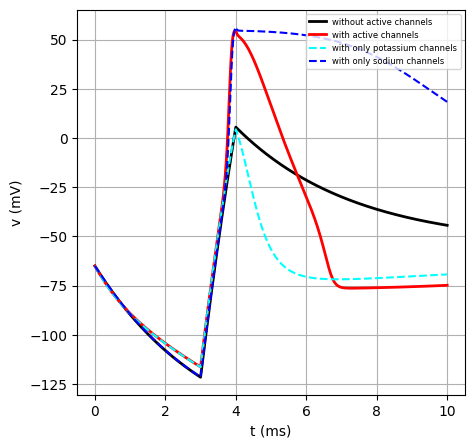

In [478]:
plt.figure(figsize=(5,5))
plt.plot(t_passive, v_passive, c='black', linewidth=2, label="without active channels")
plt.plot(t_active, v_active, c='red', linewidth=2, label="with active channels")

plt.plot(t_potassium, v_potassium, c='cyan', label="with only potassium channels", ls='--')

plt.plot(t_sodium, v_sodium, c='blue', label="with only sodium channels", ls='--')


# decorate plot
plt.legend(loc=1, fontsize=6)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
#plt.xlim(2, 4)
#plt.ylim(-125, -25)
plt.grid()

The tests confirm that the potassium current is responsible for the larger depolarization!

**The reason is that the reversal potential of the potassium is -77 mV (attractor point!)**

As a last test let us see what happens when the sodium channel is OFF and the depolarizing current is OFF.

In [479]:
soma.gnabar_sodium = 0
soma.gkbar_potassium = 0.036
soma.gl_leak = 0.0003
iclamp.amp = 0
iclamp1.amp = 0


In [480]:
h.finitialize(-65)
h.tstop = 100
h.run()

0.0

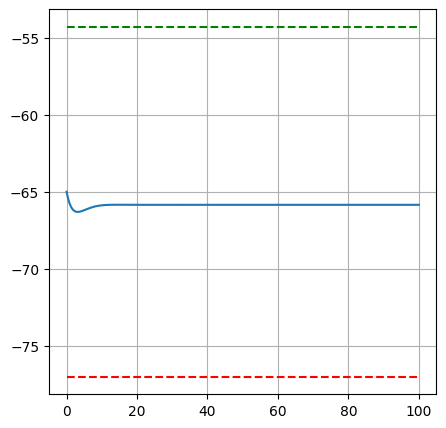

In [481]:
plt.figure(figsize=(5,5))
plt.plot(t, v) #, label="without active channels")
plt.plot([0, h.tstop], [-77, -77], 'r--')
plt.plot([0, h.tstop], [-54.3, -54.3], 'g--')
plt.grid()

Note that when $\overline{g_K}\neq 0$ and $\overline{g_{leak}}\neq 0$, the voltage settles down between -77 (mV) and -54.3 (mV).

It can be shown that if two channels are passive (e.g. $\overline{g_{leak1}}$ and $\overline{g_{leak2}}$), the equilibrium voltage is given by:

$e_{equilibrium}=\frac{\overline{g_{leak1}}\cdot e_{leak1} + \overline{g_{leak2}}\cdot e_{leak2}}{\overline{g_{leak1}}+\overline{g_{leak2}}}$

EXERCISE: Verify the previous formula! 

* switch OFF all active channels 

* insert a second leakage and assign different conductance and reversal potential values

* SUGGESTION: Make a copy of this notebook to proceed

With the active potassium channel the previous formula does not work!

In [496]:
ek = -77
el = -54.3

e_eq = (ek * soma.gkbar_potassium + el * soma.gl_leak) / (soma.gkbar_potassium + soma.gl_leak)

print("The equilibrium potential would be: %g (mV) " % e_eq)

The equilibrium potential would be: -76.8124 (mV) 


# Activation curves

In [497]:
soma.gnabar_sodium = 0.12 # 0
soma.gkbar_potassium = 0.036 # 0

iclamp.amp = 0.4
iclamp1.amp = -0.1

h.finitialize(-65)
h.tstop=10
h.run()

0.0

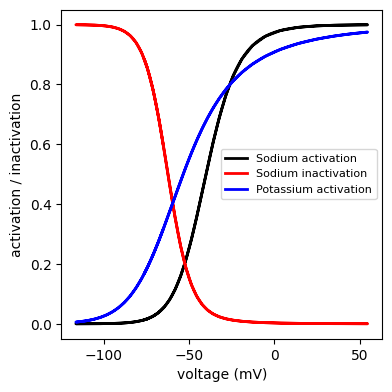

In [498]:
plt.figure(figsize=(4, 4))
plt.plot(v, minf, 'k-', lw=2, label='Sodium activation')
plt.plot(v, hinf, 'r-', lw=2, label='Sodium inactivation')
plt.plot(v, ninf, 'b-', lw=2, label='Potassium activation')
# decorate
plt.legend(loc=0, fontsize=8)
plt.xlabel('voltage (mV)', fontsize=10)
plt.ylabel('activation / inactivation', fontsize=10)
plt.tight_layout(pad=1);

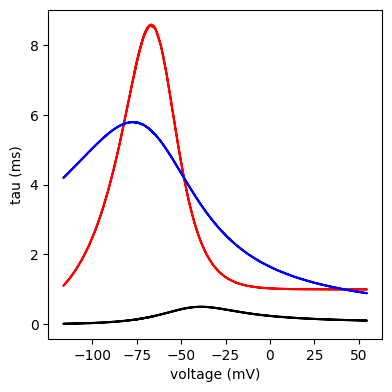

In [499]:
plt.figure(figsize=(4, 4))
plt.plot(v, mtau,'k-')
plt.plot(v, htau,'r-')
plt.plot(v, ntau,'b-')
# decorate
plt.xlabel('voltage (mV)')
plt.ylabel('tau (ms)')
plt.tight_layout(pad=1);

In [500]:
v_cc = np.copy(v)
ninf_cc = np.copy(ninf)
ntau_cc = np.copy(ntau)
minf_cc = np.copy(minf)
mtau_cc = np.copy(mtau)
hinf_cc = np.copy(hinf)
htau_cc = np.copy(htau)

# Voltage clamp protocol

In [501]:
ena = 55
ek = -77

## Potassium current


To study the potassium we apply a voltage clamp protocol and will perform:
* an hyperpolarizing phase at -120 mV
* step the voltage to a certain voltage V
* compute the plateau and the corresponding time course with the fit function
    
    $n(t)=n_\infty\cdot(1-\exp(-t/\tau_n))$

In [515]:
soma.gnabar_sodium = 0

In [502]:
def func_exp_grow(x, A, tau):
    """Fit function."""
    return np.power(A * (1-np.exp(-x/tau)), 4)

In [516]:
# voltage clamp protocol
vtest = -80
vclamp = h.VClamp(soma(0.5))
vclamp.dur[0] = 50
vclamp.amp[0] = -120
vclamp.dur[1] = 150
vclamp.amp[1] = vtest
vclamp.dur[2] = 50
vclamp.amp[2] = -120

In [518]:
# record voltage and time
v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
t = h.Vector().record(h._ref_t)                     # Time stamp vector

# record current ... 
i_vc = h.Vector().record(soma(0.5)._ref_ik_potassium)

In [519]:
h.load_file('stdrun.hoc')
h.finitialize(-65)
tstop = 250
h.tstop = tstop
h.run()

0.0

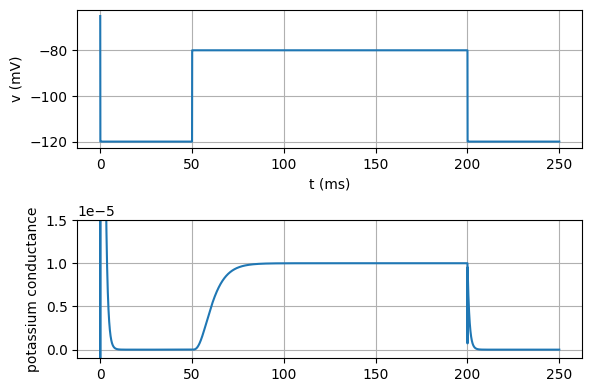

In [520]:
v_arr = np.array(v)
t_arr = np.array(t)
plt.figure(figsize=(6, 4))
plt.subplot(211)
plt.plot(t_arr, v_arr)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
#plt.xlim(vclamp.dur[0]-5)
plt.grid()
#
plt.subplot(212)
i_vc_display = np.array(i_vc)/(v_arr-ek)
plt.plot(t, i_vc_display)
# decorate
#plt.xlim(vclamp.dur[0]-5)
plt.ylim(-1e-6, 1.5e-5)
plt.ylabel('potassium conductance')
plt.grid()

plt.tight_layout(pad=1)

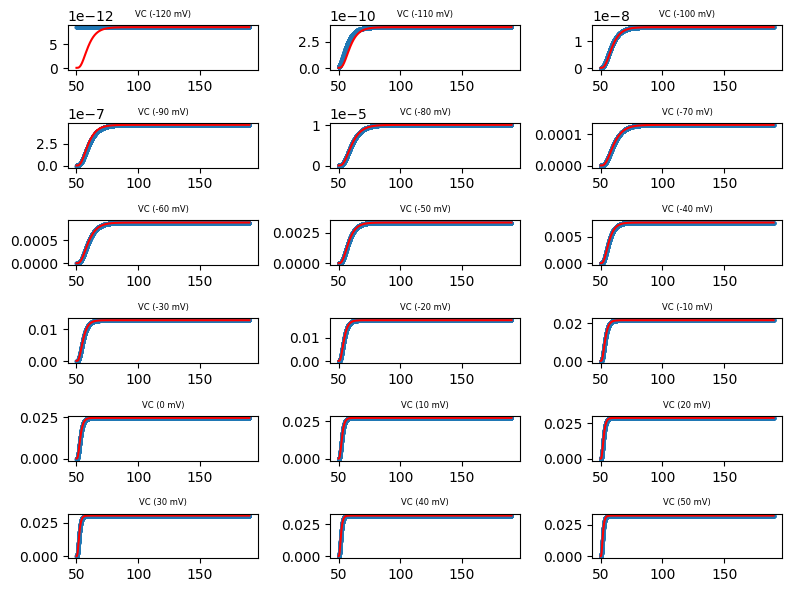

In [523]:
ik_peak = []
tauk_lst = []
vc_arr = np.arange(-120, 60, 10)
plt.figure(figsize=(8,6))
for count, vc in enumerate(vc_arr):
    vclamp.amp[1] = vc
    h.run()
    t_arr = np.array(t)
    i_vc_arr = np.array(i_vc)    
    v_arr = np.array(v)
    
    idx_t = np.where((t_arr>vclamp.dur[0])&(t_arr<(vclamp.dur[0]+vclamp.dur[1]-10)))[0]
    
    g_t = i_vc_arr[idx_t] / (v_arr[idx_t]-ek)
    g_t[g_t<=0]=0
    g_t_pow = np.power(g_t, 0.25) 
    g_t_pow[np.isnan(g_t_pow)]=0
    
    # fit
    A0 = g_t_pow.max()
    """
    Aplat = 0.95*A0
    print(A0, Aplat)
    idx_plat = np.where(g_t_pow>Aplat)[0][0]
    t_arr[idx_t][idx_plat]/10
    """
    tau0 = 5 
    popt, _ = curve_fit(func_exp_grow, t_arr[idx_t]-vclamp.dur[0], g_t, p0=[A0, tau0], 
                        bounds=([1e-10, 1e-3], [10, 50]))

    for kk in range(10):
        popt, _ = curve_fit(func_exp_grow, t_arr[idx_t]-vclamp.dur[0], g_t, p0=popt, 
                            bounds=([1e-10, 1e-3], [10, 50]))
    
    
    tauk_lst.append(popt[1])
    #plt.figure(figsize=(3,3))
    y_fit = func_exp_grow(t_arr[idx_t]-vclamp.dur[0], *popt)
    ik_peak.append(popt[0])

    plt.subplot(6, 3, count+1)
    plt.plot(t_arr[idx_t], g_t, marker='o', lw=0, markersize=2, label='vc=%g mV'%vc)     
    plt.plot(t_arr[idx_t], y_fit, 'r-')
    plt.title('VC (%g mV)' % vc, fontsize=6)
    

#plt.legend(fontsize=6)
plt.tight_layout(pad=1)




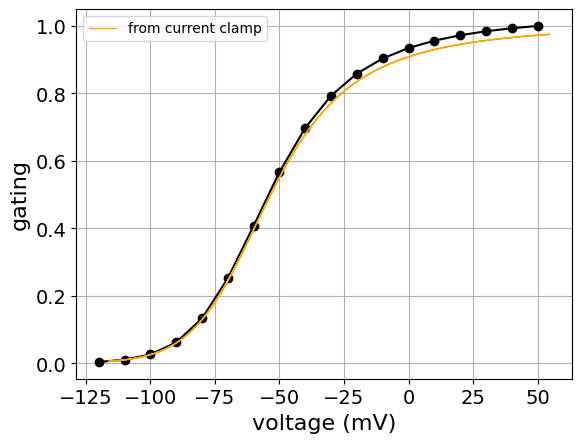

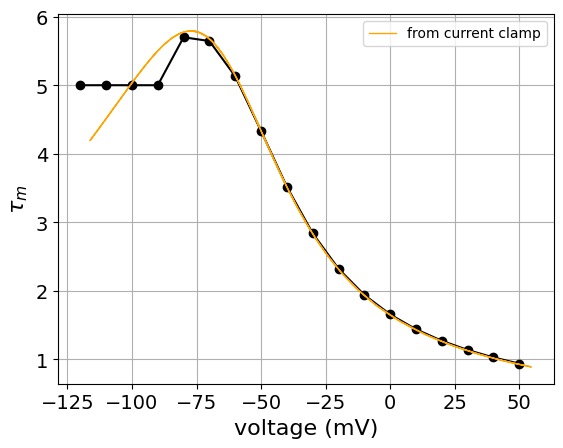

In [524]:
ik_peak = np.array(ik_peak)
ik_peak = ik_peak/ik_peak.max()

# activation plot
plt.figure()
plt.plot(vc_arr, ik_peak, 'ko-')
plt.plot(v_cc, ninf_cc, color='orange', lw=1,  label='from current clamp')
plt.xlabel('voltage (mV)', fontsize=16)
plt.ylabel('gating', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.grid()

# tau plot
plt.figure()
plt.plot(vc_arr, tauk_lst, 'ko-')
plt.plot(v_cc, ntau_cc, color='orange', lw=1, label='from current clamp')
plt.xlabel('voltage (mV)', fontsize=16)
plt.ylabel(r'$\tau_m$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.grid()

## Sodium current

In [525]:
i_vc_na = h.Vector().record(soma(0.5)._ref_ina_sodium)
soma.gnabar_sodium = 0.12

### activation

The study of the activation is much more difficult here, as the sodium current does not reach a plateau.

We will approximate the *plateau* by its peak.

In [539]:
vtest = -40
vclamp = h.VClamp(soma(0.5))
vclamp.dur[0] = 50
vclamp.amp[0] = -120
vclamp.dur[1] = 150
vclamp.amp[1] = vtest
vclamp.dur[2] = 50
vclamp.amp[2] = 120
h.tstop = vclamp.dur[0] + vclamp.dur[1] + vclamp.dur[2]

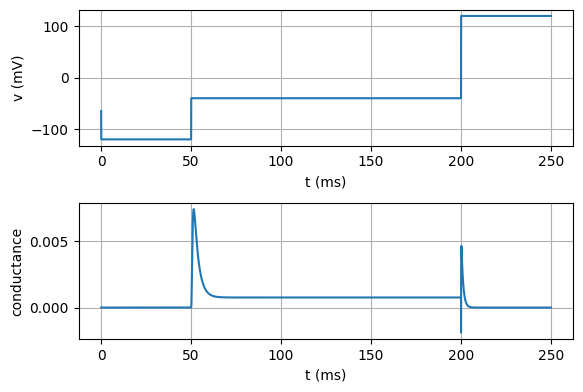

In [541]:
h.run()
v_arr = np.array(v)
t_arr = np.array(t)
plt.figure(figsize=(6, 4))
plt.subplot(211)
plt.plot(t_arr, v_arr)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)') 
plt.grid()
#
plt.subplot(212)
g_t = np.array(i_vc_na)/(v_arr-ena)
plt.plot(t, g_t)
plt.xlabel('t (ms)')
plt.ylabel('conductance') 
plt.grid()

plt.tight_layout(pad=1)

In [546]:
m_peak = []
tau_m = []
#tauk_lst = []
vc_arr = np.arange(-120, 60, 10)
for vc in vc_arr:
    vclamp.amp[1] = vc
    h.run()
    t_arr = np.array(t)
    i_vc_arr = np.array(i_vc_na)    
    v_arr = np.array(v)
    
    idx_t = np.where((t_arr>vclamp.dur[0])&(t_arr<(vclamp.dur[0]+vclamp.dur[1])))[0]
    
    g_t = i_vc_arr[idx_t] / (v_arr[idx_t]-ena)
    #g_t[g_t<=0]=0
    g_t_pow = np.power(g_t, 1/3) 
    g_t_pow[np.isnan(g_t_pow)]=0
    
    # record
    m_peak.append(g_t_pow.max())
    idx_max = np.argmax(g_t)
    time_to_peak = t_arr[idx_t][idx_max]-t_arr[idx_t][0]
    tau_m_estimated = time_to_peak / 3 # provide a rough estimate
    tau_m.append(tau_m_estimated)

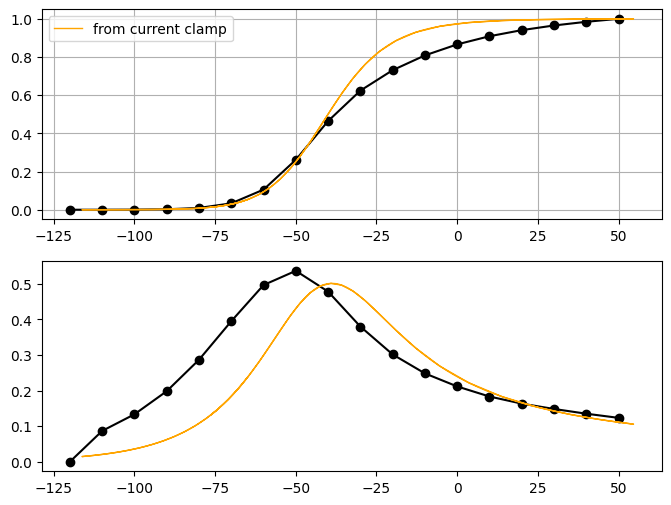

In [547]:
# activation plot
m_peak = np.array(m_peak)
m_peak /= m_peak.max()
plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(vc_arr, m_peak, 'ko-')
plt.plot(v_cc, minf_cc, color='orange', lw=1,  label='from current clamp')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(vc_arr, tau_m, 'ko-')
plt.plot(v_cc, mtau_cc, color='orange', lw=1,  label='from current clamp')


### inactivation


We get: 
$h(t)=h_\infty - (h_\infty-h_0)\cdot \exp(-t/\tau_h)$

In [253]:
def func_inact(x, A, tau):
    """Fit function."""
    return A * np.exp(-x/tau)

In [548]:
vtest = -40
vclamp.dur[0] = 50
vclamp.amp[0] = -120
vclamp.dur[1] = 150
vclamp.amp[1] = vtest
vclamp.dur[2] = 25
vclamp.amp[2] = 80
h.tstop = vclamp.dur[0] + vclamp.dur[1] + vclamp.dur[2]

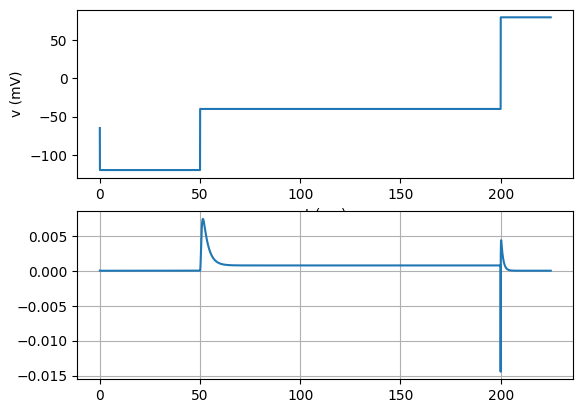

In [549]:
h.run()
v_arr = np.array(v)
t_arr = np.array(t)
plt.subplot(211)
plt.plot(t_arr, v_arr)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
#
plt.subplot(212)
i_vc_display = np.array(i_vc_na)/(v_arr-ena)
plt.plot(t, i_vc_display)
plt.grid()

#### $h_\infty$

In [550]:
vc_arr = np.arange(-100, 20, 10)

tb = vclamp.dur[0]+vclamp.dur[1]
te = tstop

gna_peak = []
t_peak = []
tau_na_lst = []

for vc in vc_arr:
    vclamp.amp[1] = vc
    h.run()
    t_arr = np.array(t)
    i_vc_arr = np.array(i_vc_na)    
    v_arr = np.array(v)
    idx_t = np.where((t_arr>tb)&(t_arr<te))[0]
    #
    time = t_arr[idx_t]-tb 
    g_t = i_vc_arr[idx_t] / (v_arr[idx_t]-ena)    
    idx_peak = np.argmax(g_t)
    t_peak.append(time[idx_peak])
    gna_peak.append(g_t[idx_peak])

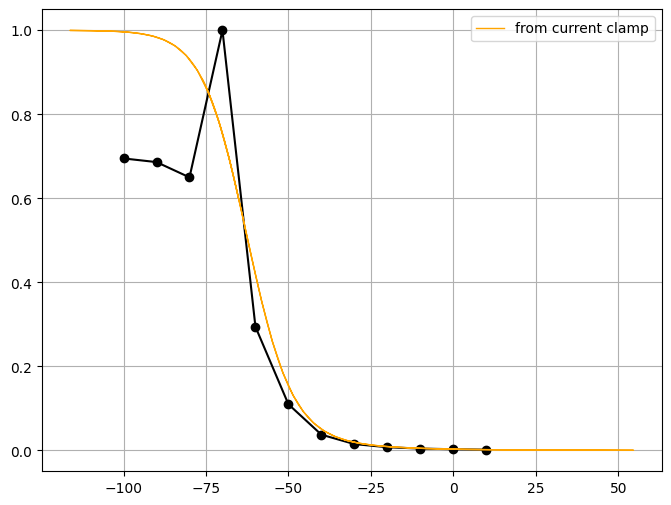

In [551]:
plt.figure(figsize=(8,6))    
gna_peak = np.array(gna_peak)
gna_peak /= gna_peak.max()
plt.plot(vc_arr, gna_peak, 'ko-')    
plt.plot(v_cc, hinf_cc, color='orange', lw=1,  label='from current clamp')
plt.legend()
plt.grid()

#### $\tau_h$

TO DO (requires ad-hoc PROTOCOL)

In [ ]:
dur_test = 100
vclamp = h.VClamp(soma(0.5))
vclamp.dur[0] = 50
vclamp.amp[0] = 120
vclamp.dur[1] = dur_test
vclamp.amp[1] = -120
vclamp.dur[2] = 20
vclamp.amp[2] = 120
h.tstop = vclamp.dur[0] + vclamp.dur[1] + vclamp.dur[2]
print(h.tstop)

In [ ]:
vclamp.amp[2] = -80
for dur_test in np.arange(0.1,30,2):
    vclamp.dur[1] = dur_test
    h.tstop = vclamp.dur[0] + vclamp.dur[1] + vclamp.dur[2]
    h.run()
    v_arr = np.array(v)
    t_arr = np.array(t)
    plt.subplot(121)
    plt.plot(t_arr, v_arr)
    plt.xlabel('t (ms)')
    plt.ylabel('v (mV)')
    plt.grid()
    #
    plt.subplot(122)
    i_vc_display = np.array(i_vc_na)/(v_arr-ena)
    plt.plot(t, i_vc_display)
    plt.grid()
    
    tb = vclamp.dur[0]+vclamp.dur[1]
    te = tstop
    idx_t = np.where((t_arr>tb)&(t_arr<te))[0]
    print(dur_test, i_vc_display[idx_t].max())